#Problema a ser solucionado:

Atualmente, a Polícia Rodoviária Federal tem sob sua responsabilidade a segurança viária e a prevenção e repressão qualificada ao crime em mais de 75 mil quilômetros de rodovias e estradas federais em todos os estados brasileiros e nas áreas de interesse da União. Uma instituição que provê a pronta resposta federal às mais diversas demandas de segurança pública do Brasil. A polícia Rodoviária Federal tem como missão, visão e valores, os itens abaixo:

✓ Proteger a vida

✓ Proteger os direitos humanos

✓ Proteger o meio ambiente

✓ Segurança Pública

✓ Cidadania nas rodovias

✓ Integridade e Transparência

Neste projeto, oferecemos uma análise abrangente de dados relacionados a acidentes, estruturados por todas as causas e tipos de acidentes. Nosso enfoque se concentra na identificação de indicadores cruciais, visando direcionar medidas que promovam a ampliação da segurança viária. Além disso, buscamos aprimorar a qualidade de vida tanto de motoristas quanto de pedestres, enquanto aliviamos o ônus imposto ao sistema de saúde, diretamente impactado pela frequência elevada de acidentes nas rodovias.




#Dados Disponíveis:

Fonte: Polícia Rodoviária Federal

https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf

O conjunto de dados usado serão os seguintes arquivos:
* acidentes2018_todas_causas_tipos.csv
* acidentes2019_todas_causas_tipos.csv
* acidentes2020_todas_causas_tipos.csv
* acidentes2021_todas_causas_tipos.csv
* acidentes2022_todas_causas_tipos.csv
* acidentes2023_todas_causas_tipos.csv


#Inicialização do PySpark


In [1]:
# Instalar as dependências

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark


In [2]:
# Configurar as variáveis de ambiente

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Tornar o PySpark "importável"

import findspark
findspark.init('spark-3.4.1-bin-hadoop3')

In [3]:
# Criando sessão do Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = spark.sparkContext

#Importar Bibliotecas


In [27]:
# Bibliotecas do PySpark
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql.types import DateType, StringType, FloatType, BooleanType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Bibliotecas para acessar os arquivos
import os
import zipfile
import re
import gdown

# Bibilioteca do Pandas
import pandas as pd

# Importando biblioteca gráfica
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


#Baixar Dados do site da Policia Rodoviária Federal

In [5]:
# Links dados PRF
A2023 = 'https://drive.google.com/file/d/1-caam_dahYOf2eorq4mez04Om6DD5d_3/view'
A2022 = 'https://drive.google.com/file/d/1wskEgRC3ame7rncSDQ7qWhKsoKw1lohY/view'
A2021 = 'https://drive.google.com/file/d/1Gk3U6cMOZIevsDZHLi6J503xoCRS_lnI/view'
A2020 = 'https://drive.google.com/file/d/1yQtVOsAlupPHQVVTmbJo0NR3XMzgHANO/view'
A2019 = 'https://drive.google.com/file/d/1DAJYKVfkTcPhQodSmHp9rsG1Q8XJW-m3/view'
A2018 = 'https://drive.google.com/file/d/1J-012nSnIafOASNFvIYY_vDKKpM51w5_/view'

linksprf = [A2018, A2019, A2020, A2021, A2022, A2023]

# Diretorio para baixar arquivos
diretorio_csv = '/content/Dados_PRF/zipados/'

# Fazer o download de cada link
for link in linksprf:
  gdown.download(f'https://drive.google.com/uc?id={link[32:65]}',
                 diretorio_csv,
                 quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1J-012nSnIafOASNFvIYY_vDKKpM51w5_
To: /content/Dados_PRF/zipados/acidentes2018_todas_causas_tipos.zip
100%|██████████| 9.67M/9.67M [00:00<00:00, 52.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DAJYKVfkTcPhQodSmHp9rsG1Q8XJW-m3
To: /content/Dados_PRF/zipados/acidentes2019_todas_causas_tipos.zip
100%|██████████| 9.71M/9.71M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yQtVOsAlupPHQVVTmbJo0NR3XMzgHANO
To: /content/Dados_PRF/zipados/acidentes2020_todas_causas_tipos.zip
100%|██████████| 9.74M/9.74M [00:00<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gk3U6cMOZIevsDZHLi6J503xoCRS_lnI
To: /content/Dados_PRF/zipados/acidentes2021_todas_causas_tipos.zip
100%|██████████| 11.3M/11.3M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wskEgRC3ame7rncSDQ7qWhKsoKw1lohY
To: /content/Dados_PRF/zipados/acidentes2022_todas_causas_tipos.zip
100%|██████████| 11.

#Importação dos dados

In [7]:
arquivos = '/content/Dados_PRF/'

for arquivo_zip in os.listdir(diretorio_csv):
  caminho_completo = diretorio_csv + arquivo_zip

# Extração dos arquivos
  with zipfile.ZipFile(caminho_completo, 'r') as zip_ref:
    zip_ref.extractall(arquivos)

#Unir datasets

In [8]:
# Configurar SparkSession
spark = SparkSession.builder.appName("UnirDadosPRF").getOrCreate()


In [9]:
# Diretório onde os arquivos CSV foram extraídos
diretorio_csv = '/content/Dados_PRF/'

# Lista para armazenar os DataFrames
dataframes = []

for arquivo_csv in os.listdir(diretorio_csv):
    caminho_completo = diretorio_csv + arquivo_csv
    if os.path.isfile(caminho_completo):
        if '_' in arquivo_csv:
            # Extrair o ano do nome do arquivo
            ano_match = re.search(r'\d{4}', arquivo_csv)
            if ano_match:
                ano = int(ano_match.group())
                # Carregar e ajustar arquivos CSV
                df = spark.read.option("header", "true").option("sep", ";").option("encoding", "latin1").csv(caminho_completo, inferSchema=True)
                # Adicionar coluna 'ano'
                df = df.withColumn('ano', f.lit(ano))  # Usando a função 'lit' do PySpark
                # Adicionar DataFrame à lista
                dataframes.append(df)

# Unir DataFrames
dados_unidos = dataframes[0]
for df in dataframes[1:]:
    dados_unidos = dados_unidos.union(df)


#Exploratory Data Analysis





###Análises iniciais

In [10]:
# Formato do dataset
print((dados_unidos.count(), len(dados_unidos.columns)))

(2449959, 38)


In [11]:
# Estrutura do dataset
dados_unidos.printSchema()

root
 |-- id: double (nullable = true)
 |-- pesid: string (nullable = true)
 |-- data_inversa: date (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- horario: timestamp (nullable = true)
 |-- uf: string (nullable = true)
 |-- br: string (nullable = true)
 |-- km: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- causa_principal: string (nullable = true)
 |-- causa_acidente: string (nullable = true)
 |-- ordem_tipo_acidente: integer (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- classificacao_acidente: string (nullable = true)
 |-- fase_dia: string (nullable = true)
 |-- sentido_via: string (nullable = true)
 |-- condicao_metereologica: string (nullable = true)
 |-- tipo_pista: string (nullable = true)
 |-- tracado_via: string (nullable = true)
 |-- uso_solo: string (nullable = true)
 |-- id_veiculo: string (nullable = true)
 |-- tipo_veiculo: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- ano_fabricacao_veicul

In [17]:
# Primeiras 5 linhas do dataset
dados_unidos.show(5, truncate=False)

+--------+------+------------+-----------+-------------------+---+---+-----+------------+---------------+---------------------------+-------------------+---------------------------+----------------------+-----------+-----------+----------------------+----------+-----------+--------+----------+------------+-------------------------------------------------------------------------------------------------------------+----------------------+--------------+-------------+-----+---------+------+-------------+--------------+------+------------+------------+--------+---------+--------------+----+
|id      |pesid |data_inversa|dia_semana |horario            |uf |br |km   |municipio   |causa_principal|causa_acidente             |ordem_tipo_acidente|tipo_acidente              |classificacao_acidente|fase_dia   |sentido_via|condicao_metereologica|tipo_pista|tracado_via|uso_solo|id_veiculo|tipo_veiculo|marca                                                                                              

In [20]:
# Verificar existência de dados nulos
dados_unidos.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in dados_unidos.columns]).show()


+---+-----+------------+----------+-------+---+---+---+---------+---------------+--------------+-------------------+-------------+----------------------+--------+-----------+----------------------+----------+-----------+--------+----------+------------+------+----------------------+--------------+-------------+-----+----+------+-------------+--------------+------+--------+---------+--------+---------+---+---+
| id|pesid|data_inversa|dia_semana|horario| uf| br| km|municipio|causa_principal|causa_acidente|ordem_tipo_acidente|tipo_acidente|classificacao_acidente|fase_dia|sentido_via|condicao_metereologica|tipo_pista|tracado_via|uso_solo|id_veiculo|tipo_veiculo| marca|ano_fabricacao_veiculo|tipo_envolvido|estado_fisico|idade|sexo|ilesos|feridos_leves|feridos_graves|mortos|latitude|longitude|regional|delegacia|uop|ano|
+---+-----+------------+----------+-------+---+---+---+---------+---------------+--------------+-------------------+-------------+----------------------+--------+-----------+

In [18]:
# Estatísticas Descritivas
dados_unidos.describe().show()


+-------+-----------------+-----------------+-----------+-------+------------------+------------------+---------------+---------------+--------------------+-------------------+--------------------+----------------------+---------+-------------+----------------------+----------+-----------+--------+-----------------+------------+--------------------+----------------------+--------------+-------------+-----------------+-------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+--------+---------+----------------+------------------+
|summary|               id|            pesid| dia_semana|     uf|                br|                km|      municipio|causa_principal|      causa_acidente|ordem_tipo_acidente|       tipo_acidente|classificacao_acidente| fase_dia|  sentido_via|condicao_metereologica|tipo_pista|tracado_via|uso_solo|       id_veiculo|tipo_veiculo|               marca|ano_fabricacao_veiculo|tipo_envolvido|

In [25]:
# Quantidade de ocorrências por ano
dados_unidos.groupBy('ano').count().orderBy(f.desc('count')).show()


+----+------+
| ano| count|
+----+------+
|2022|519023|
|2021|449018|
|2023|430288|
|2020|394735|
|2019|332027|
|2018|324868|
+----+------+



In [24]:
# Média de Idade dos Envolvidos
media_idade = dados_unidos.select(f.avg('idade')).show()


+-----------------+
|       avg(idade)|
+-----------------+
|39.51904982473519|
+-----------------+



In [20]:
# Ocorrência por dia da semana
contagem_dia_semana = dados_unidos.groupBy('dia_semana').count().orderBy(f.desc('count')).show()

+-------------+------+
|   dia_semana| count|
+-------------+------+
|      domingo|427150|
|       sábado|412156|
|  sexta-feira|379197|
|segunda-feira|320180|
| quinta-feira|312233|
| quarta-feira|306865|
|  terça-feira|292178|
+-------------+------+



In [21]:
contagem_causa_acidente= dados_unidos.groupBy('causa_acidente').count().orderBy(f.desc('count')).show()

+--------------------+------+
|      causa_acidente| count|
+--------------------+------+
|Falta de Atenção ...|338058|
|Velocidade Incomp...|279760|
|Reação tardia ou ...|177537|
|Desobediência às ...|142249|
|Ausência de reaçã...|135337|
|Condutor deixou d...|101241|
|Acessar a via sem...| 87445|
|Não guardar distâ...| 81597|
|   Condutor Dormindo| 77206|
|Manobra de mudanç...| 77103|
|Ingestão de álcoo...| 74819|
|Ultrapassagem Ind...| 74040|
|  Ingestão de Álcool| 70492|
|  Pista Escorregadia| 56852|
|Transitar na cont...| 50735|
|Defeito Mecânico ...| 43763|
|               Chuva| 40408|
|Avarias e/ou desg...| 38497|
|Demais falhas mec...| 32010|
|    Animais na Pista| 27164|
+--------------------+------+
only showing top 20 rows



Primeiros Insights

* O conjunto de dados contém 2.449.959 registros.
* Os registros abrangem um período de anos, começando em 2018 e indo até 2023.
* Os acidentes ocorrem em todos os dias da semana,porém podemos observar que o dia da semana em que ocorrem menos acidentes seria Terça-feira e o dia em que ocorrem mais acidentes, seria no Domingo.
* O ano de maior ocorrências até então foi 2022.
* A média de idade dos envolvidos é 40 anos.
* A maioria dos acidentes ocorre em áreas urbanas.
* A causa principal causa dos acidentes é "Falta de atenção a condução".


###Outras análises complementares

In [31]:
# Total de feridos graves e mortes por ano
analise_por_ano = dados_unidos.groupBy('ano').agg(f.sum('feridos_graves').alias('total_feridos_graves'), f.sum('mortos').alias('total_mortos'))

analise_por_ano.show()


+----+--------------------+------------+
| ano|total_feridos_graves|total_mortos|
+----+--------------------+------------+
|2023|               48441|       19843|
|2018|               33670|       11983|
|2020|               45235|       17841|
|2021|               53571|       20921|
|2022|               59117|       24920|
|2019|               36464|       12682|
+----+--------------------+------------+



In [32]:
# Total de  feridos graves e mortes por estado
analise_por_estado = dados_unidos.groupBy('uf').agg(f.sum('feridos_graves').alias('total_feridos_graves'), f.sum('mortos').alias('total_mortos'))

analise_por_estado.show()


+---+--------------------+------------+
| uf|total_feridos_graves|total_mortos|
+---+--------------------+------------+
| SC|               24154|        7086|
| RO|                8495|        2736|
| PI|                8851|        4455|
| AM|                 766|         379|
| RR|                1076|         488|
| GO|               15261|        6338|
| TO|                3797|        1865|
| MT|                8849|        4950|
| SP|               12929|        4518|
| ES|               10026|        1876|
| PB|                9173|        3304|
| RS|               17523|        5996|
| MS|               10140|        4259|
| AL|                2815|        1045|
| MG|               37726|       13880|
| PA|                7482|        4826|
| BA|               14990|        8843|
| SE|                2401|         833|
| PE|               13424|        6010|
| CE|                8018|        3149|
+---+--------------------+------------+
only showing top 20 rows



In [33]:
# Total de acidentes envolvendo crianças (idade menor que 12 anos)
acidentes_com_criancas = dados_unidos.filter(f.col('idade').cast('int') < 12)

numero_acidentes_com_criancas = acidentes_com_criancas.count()

print(f'Número de acidentes com crianças: {numero_acidentes_com_criancas}')


Número de acidentes com crianças: 59416


In [34]:
# Total de acidentes fatais com crianças por estado
mortes_criancas_por_estado = acidentes_com_criancas.groupBy('uf').agg(f.sum('mortos').alias('total_mortes_criancas'))

mortes_criancas_por_estado = mortes_criancas_por_estado.orderBy(f.col('total_mortes_criancas').desc())

mortes_criancas_por_estado.show()


+---+---------------------+
| uf|total_mortes_criancas|
+---+---------------------+
| MG|                  337|
| PR|                  262|
| BA|                  233|
| GO|                  215|
| SC|                  184|
| MS|                  166|
| SP|                  130|
| MT|                  107|
| PI|                   97|
| PA|                   96|
| RS|                   93|
| PE|                   87|
| MA|                   80|
| RJ|                   73|
| PB|                   42|
| ES|                   41|
| CE|                   41|
| RO|                   36|
| AC|                   15|
| TO|                   14|
+---+---------------------+
only showing top 20 rows



#Perguntas sobre o Dataset

Pergunta 1:
Qual é o estado com a maior taxa de acidentes fatais por ano e qual é a principal causa desses acidentes?

Pergunta 2:
Qual é o perfil demográfico das vítimas mais comuns em acidentes graves e mortes envolvendo crianças menores de 12 anos?

Pergunta 3:
Qual a principal causa de acidente resultante em morte de crianças?

Pergunta 4:
Qual é o tipo de acidente mais comum em rodovias durante condições meteorológicas adversas?

Pergunta 5:
Qual é a relação entre o tipo de pista (simples, dupla, etc.) e a gravidade dos acidentes (número de mortos e feridos graves)?

Pergunta 6:
Existe alguma tendência ou padrão sazonal nos acidentes de trânsito ao longo dos anos?

Pergunta 7:
Qual é a condição meteorológica mais apontadas no acidentes graves e mortes ?

Pergunta 8:
Qual é a relação entre a hora do dia e a gravidade dos acidentes?

Pergunta 9:
Qual é o tipo de veículo mais frequentemente envolvido em acidentes graves?

Pergunta 10:
Existe alguma relação entre o Tipo da via e a gravidade dos acidentes?

###Pergunta 1:
###Qual é o estado com a maior taxa de acidentes fatais por ano e qual é a principal causa desses acidentes?

In [28]:
# Filtrar acidentes fatais
acidentes_fatais = dados_unidos.filter(f.col('classificacao_acidente') == 'Com Vítimas Fatais')

# Agrupar por ano, estado e contar o número de acidentes fatais
acidentes_fatais_por_estado_ano = acidentes_fatais.groupBy('ano', 'uf').agg(f.count('id').alias('num_acidentes_fatais'))

# Calcular o total de acidentes por estado e ano
total_acidentes_por_estado_ano = dados_unidos.groupBy('ano', 'uf').agg(f.count('id').alias('total_acidentes'))

# Calcular a taxa de acidentes fatais por estado e ano
taxa_acidentes_fatais = acidentes_fatais_por_estado_ano.join(total_acidentes_por_estado_ano, ['ano', 'uf'])
taxa_acidentes_fatais = taxa_acidentes_fatais.withColumn('taxa_acidentes_fatais', (f.col('num_acidentes_fatais') / f.col('total_acidentes')) * 100)

# Identificar o estado com a maior taxa de acidentes fatais por ano
window_spec = Window.partitionBy('ano').orderBy(f.col('taxa_acidentes_fatais').desc())

estado_maior_taxa_acidentes_fatais = taxa_acidentes_fatais.withColumn('rank', rank().over(window_spec)).filter(f.col('rank') == 1)

# Identificar a principal causa de acidentes fatais nesse estado
principal_causa_acidentes_fatais = acidentes_fatais.filter(f.col('uf') == estado_maior_taxa_acidentes_fatais.select('uf').first()[0])
principal_causa_acidentes_fatais = principal_causa_acidentes_fatais.groupBy('causa_acidente').agg(f.count('id').alias('num_acidentes')).orderBy(f.col('num_acidentes').desc()).limit(1)

# Mostrar resultados
print("Estado com a maior taxa de acidentes fatais por ano:")
estado_maior_taxa_acidentes_fatais.show()

print("Principal causa de acidentes fatais nesse estado:")
principal_causa_acidentes_fatais.show()

Estado com a maior taxa de acidentes fatais por ano:
+----+---+--------------------+---------------+---------------------+----+
| ano| uf|num_acidentes_fatais|total_acidentes|taxa_acidentes_fatais|rank|
+----+---+--------------------+---------------+---------------------+----+
|2018| MA|                1553|           7287|    21.31192534650748|   1|
|2019| AM|                 165|            610|   27.049180327868854|   1|
|2020| MA|                2542|           9808|    25.91761827079935|   1|
|2021| BA|                7785|          26333|   29.563665362852692|   1|
|2022| PA|                5108|          16278|    31.37977638530532|   1|
|2023| PA|                3389|          11861|    28.57263299890397|   1|
+----+---+--------------------+---------------+---------------------+----+

Principal causa de acidentes fatais nesse estado:
+--------------------+-------------+
|      causa_acidente|num_acidentes|
+--------------------+-------------+
|Falta de Atenção ...|         1330

Resposta:

Estado com a maior taxa de acidentes fatais por ano:

Em 2018, o estado do Maranhão (MA) teve a maior taxa de acidentes fatais, com 21.31% dos acidentes sendo fatais.

Em 2019, o estado do Amazonas (AM) teve a maior taxa de acidentes fatais, com 27.05% dos acidentes sendo fatais.

Em 2020, novamente o estado do Maranhão (MA) liderou com uma taxa de 25.92%.

Em 2021, foi o estado da Bahia (BA) com 29.56% de acidentes fatais.

Em 2022, o estado do Pará (PA) teve 31.38% dos acidentes sendo fatais.

Em 2023, o estado do Pará (PA) manteve a liderança com 28.57% de acidentes fatais.

Principal causa de acidentes fatais nesse estado:

A principal causa de acidentes fatais nos estados mencionados foi "Falta de Atenção à Condução", com 1330 acidentes fatais registrados.

###Pergunta 2:

###Qual é o perfil demográfico das vítimas mais comuns em acidentes graves e mortes envolvendo crianças menores de 12 anos?

In [35]:
# Filtrar acidentes graves com crianças menores de 12 anos
acidentes_graves_criancas = dados_unidos.filter((f.col('idade').cast('int') < 12) & (f.col('feridos_graves') > 0))

# Filtrar acidentes fatais com crianças menores de 12 anos
acidentes_fatais_criancas = dados_unidos.filter((f.col('idade').cast('int') < 12) & (f.col('mortos') > 0))

# Calcular idade média e contagem de vítimas para acidentes graves por sexo
perfil_demografico_graves = acidentes_graves_criancas.groupBy('sexo').agg(f.avg('idade').alias('idade_media_graves'), f.count('idade').alias('numero_vitimas_graves'))

# Calcular idade média e contagem de vítimas para acidentes fatais por sexo
perfil_demografico_fatais = acidentes_fatais_criancas.groupBy('sexo').agg(f.avg('idade').alias('idade_media_fatais'), f.count('idade').alias('numero_vitimas_fatais'))

# Mostrar o perfil demográfico das vítimas em acidentes graves
print("Perfil demográfico das vítimas em acidentes graves:")
perfil_demografico_graves.show()

# Mostrar o perfil demográfico das vítimas em acidentes fatais
print("Perfil demográfico das vítimas em acidentes fatais:")
perfil_demografico_fatais.show()


Perfil demográfico das vítimas em acidentes graves:
+---------+------------------+---------------------+
|     sexo|idade_media_graves|numero_vitimas_graves|
+---------+------------------+---------------------+
| Feminino| 5.600749495531853|                 3469|
|Masculino| 6.113258317025441|                 4088|
+---------+------------------+---------------------+

Perfil demográfico das vítimas em acidentes fatais:
+---------+------------------+---------------------+
|     sexo|idade_media_fatais|numero_vitimas_fatais|
+---------+------------------+---------------------+
| Feminino| 5.811849479583667|                 1249|
|Masculino| 5.662852112676056|                 1136|
+---------+------------------+---------------------+



Resposta:

Perfil Demográfico de crianças Vítimas em Acidentes Graves:

Feminino: A idade média das vítimas femininas em acidentes graves é aproximadamente 6 anos. Houve um total de 3.469 vítimas do sexo feminino em acidentes graves.

Masculino: A idade média das vítimas masculinas em acidentes graves é aproximadamente 6 anos. Houve um total de 4.088 vítimas do sexo masculino em acidentes graves.

Perfil Demográfico das Vítimas em Acidentes Fatais:

Feminino: A idade média das vítimas femininas em acidentes fatais é aproximadamente 6 anos. Houve um total de 1.249 vítimas do sexo feminino em acidentes fatais.

Masculino: A idade média das vítimas masculinas em acidentes fatais é aproximadamente 6 anos. Houve um total de 1.136 vítimas do sexo masculino em acidentes fatais.

Esses resultados indicam que, tanto em acidentes graves quanto em acidentes fatais envolvendo crianças menores de 12 anos, as vítimas tem predominantemente idades em torno de 6 anos. Além disso, não há uma diferença significativa na idade média entre vítimas femininas e masculinas em ambos os tipos de acidentes. No entanto, é importante notar que há um maior número de vítimas masculinas em ambos os cenários, tanto em acidentes graves quanto em acidentes fatais.

###Pergunta 3:
###Qual a principal causa de acidente resultante em morte de crianças?

In [60]:
# Contar o número de acidentes com mortes de crianças por motivo
causas_mortes_criancas = acidentes_fatais_criancas.groupBy('causa_acidente').count().orderBy(f.desc('count'))

maior_causa_acidentes = causas_mortes_criancas.first()

# Mostrar o principal causa das vítimas crianças em acidentes fatais

print("Principal causa acidentes fatais com crianças:")
maior_causa_acidentes

Principal causa das vítimas crianças em acidentes fatais:


Row(causa_acidente='Velocidade Incompatível', count=1)

<ipython-input-61-6f7ba300a603>:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


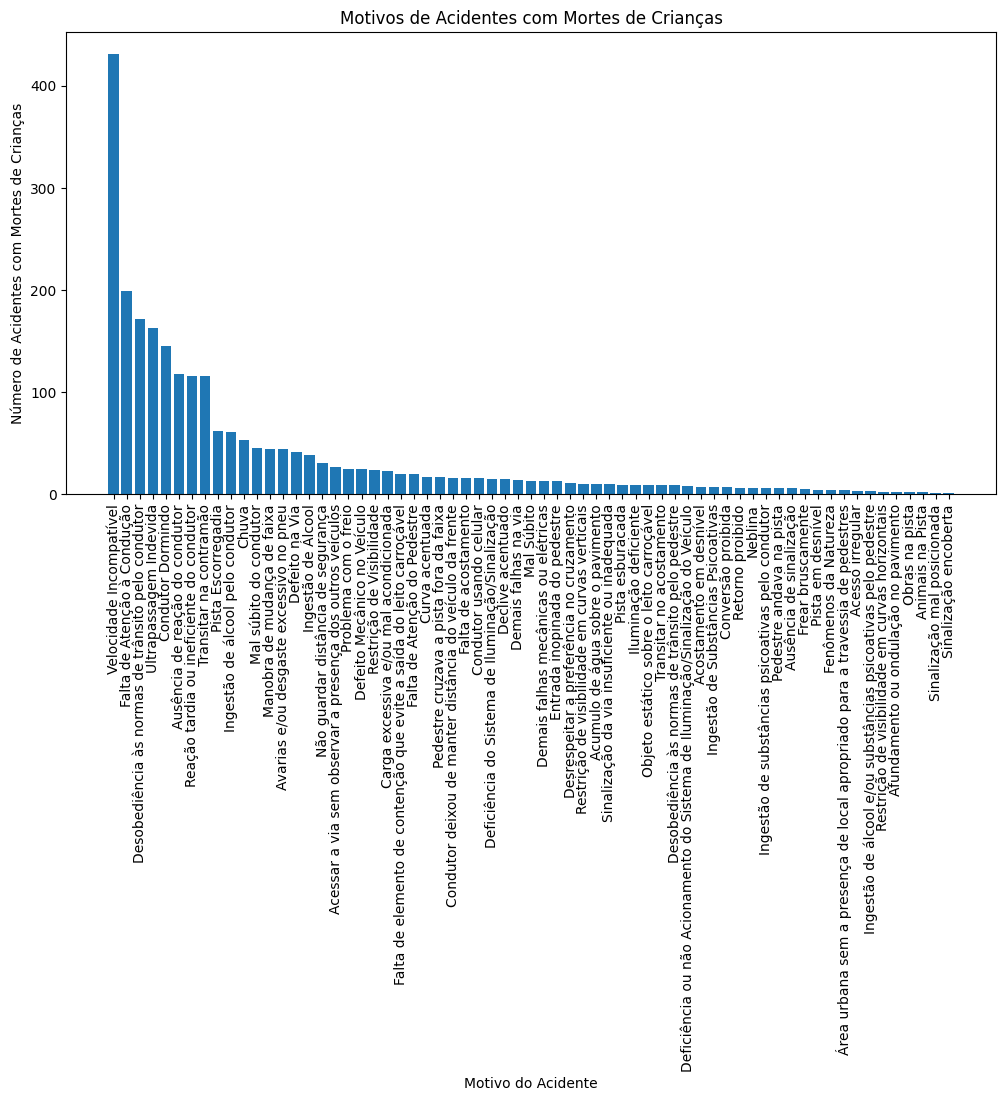

In [61]:
# Visualização:
df_pandas = acidentes_fatais_criancas.toPandas().sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_pandas['causa_acidente'], df_pandas['count'])
plt.xlabel('Motivo do Acidente')
plt.ylabel('Número de Acidentes com Mortes de Crianças')
plt.title('Motivos de Acidentes com Mortes de Crianças')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


Resposta:

A principal causa de acidente resultante em mortes de crianças é "Velocidade Incompatível", seguido por "Falta de Atenção à Condução" e "Desobediência às normas de transito pelo condutor".

###Pergunta 4:

###Qual é o tipo de acidente mais comum em rodovias durante condições meteorológicas adversas?

In [64]:
# Filtrar acidentes durante condições meteorológicas adversas

acidentes_meteorologicas_adversas = dados_unidos.filter(f.col('condicao_metereologica').isin(['Chuva', 'Neblina', 'Nevoeiro', 'Garoa', 'Vento', 'Granizo']))

# Contar o número de acidentes por tipo durante condições meteorológicas adversas
tipos_acidentes_meteorologicas_adversas = acidentes_meteorologicas_adversas.groupBy('tipo_acidente').count()

# Ordenar os resultados pelo número de ocorrências em ordem decrescente
tipos_acidentes_meteorologicas_adversas = tipos_acidentes_meteorologicas_adversas.orderBy(f.col('count').desc())

# Mostrar o tipo de acidente mais comum durante condições meteorológicas adversas
tipos_acidentes_meteorologicas_adversas.show()

+--------------------+-----+
|       tipo_acidente|count|
+--------------------+-----+
|Saída de leito ca...|62154|
|    Colisão traseira|36871|
|     Colisão frontal|29658|
|         Capotamento|27412|
|          Tombamento|27157|
|  Colisão com objeto|22540|
|Colisão com objet...|16738|
| Colisão transversal|15853|
|Queda de ocupante...|14162|
|     Colisão lateral|10241|
|Colisão lateral m...| 6937|
|       Engavetamento| 6391|
|Atropelamento de ...| 6376|
|Colisão lateral s...| 5393|
|Derramamento de c...| 2647|
|            Incêndio| 1545|
|Atropelamento de ...|  940|
|    Eventos atípicos|  792|
|Colisão com objet...|  536|
|     Danos eventuais|  457|
+--------------------+-----+
only showing top 20 rows



Resposta:

Durante condições meteorológicas adversas, os tipos de acidentes mais comuns em rodovias, são os seguintes:

Saída de leito carroçável: O tipo mais frequente de acidente durante condições meteorológicas adversas é quando o veículo sai da pista ou estrada, muitas vezes devido à falta de aderência em superfícies molhadas ou escorregadias. Houve 62.154 ocorrências desse tipo.

Colisão traseira: Este tipo de acidente ocorre quando um veículo colide com a traseira de outro. Durante condições meteorológicas adversas, houve 36.871 casos desse tipo.

Colisão frontal: Acidentes frontais envolvem colisões diretas entre os para-choques dianteiros de dois veículos. Durante condições meteorológicas adversas, houve 29.658 acidentes frontais.

Capotamento: Neste tipo de acidente, o veículo vira de cabeça para baixo. Houve 27.412 capotamentos durante condições meteorológicas adversas.

Tombamento: Refere-se a situações em que um veículo vira de lado. Durante condições meteorológicas adversas, houve 27.157 tombamentos.


###Pergunta 5:
###Qual é a relação entre o tipo de pista (simples, dupla, etc.) e a gravidade dos acidentes (número de mortos e feridos graves)?

In [65]:
# Agrupar dados pelo tipo de pista e calcular a média de mortos e feridos graves
relacao_tipo_pista_gravidade = dados_unidos.groupBy('tipo_pista').agg(f.mean('mortos').alias('media_mortos'), f.mean('feridos_graves').alias('media_feridos_graves'))

# Mostrar o resultado
relacao_tipo_pista_gravidade.show()

+----------+--------------------+--------------------+
|tipo_pista|        media_mortos|media_feridos_graves|
+----------+--------------------+--------------------+
|     Dupla|0.029187080314967546| 0.09716439193765636|
|   Simples| 0.05711163393898885| 0.12663016072767388|
|  Múltipla|0.023373754918674345|  0.0896458554472643|
+----------+--------------------+--------------------+



Resposta:

A análise da relação entre o tipo de pista e a gravidade dos acidentes revela o seguinte:

Dupla: A média de mortos em acidentes em pistas duplas é aproximadamente 0,029 (ou cerca de 2,9% de chance de fatalidade). A média de feridos graves é cerca de 0,097 (ou cerca de 9,7% de chance de lesões graves) em acidentes nesse tipo de pista.

Simples: Em pistas simples, a média de mortos é um pouco mais alta, aproximadamente 0,057 (cerca de 5,7% de chance de fatalidade). A média de feridos graves é cerca de 0,127 (ou cerca de 12,7% de chance de lesões graves) em acidentes nessas pistas.

Múltipla: Para pistas múltiplas, a média de mortos é cerca de 0,023 (ou cerca de 2,3% de chance de fatalidade). A média de feridos graves é aproximadamente 0,090 (ou cerca de 9% de chance de lesões graves) em acidentes nessas pistas.

Esses resultados sugerem que, em média, acidentes em pistas simples tendem a ser mais graves em termos de fatalidades e ferimentos graves, seguidos por pistas múltiplas e, em seguida, pistas duplas. Isso indica que há uma correlação entre o tipo de pista e a gravidade dos acidentes, com pistas simples mostrando uma tendência a serem mais perigosas em termos de consequências graves.






###Pergunta 6:
###Existe alguma tendência ou padrão sazonal nos acidentes de trânsito ao longo dos anos?

In [66]:
# Extrair o ano e o mês de cada registro
dados_com_anomes = dados_unidos.withColumn('ano', f.year('data_inversa')).withColumn('mes', f.month('data_inversa'))

# Agrupar por ano e mês e contar o número de acidentes em cada mês ao longo dos anos
acidentes_por_mes = dados_com_anomes.groupBy('ano', 'mes').count()

# Mostrar os resultados
acidentes_por_mes.show()

+----+---+-----+
| ano|mes|count|
+----+---+-----+
|2023|  3|45733|
|2023|  2|38768|
|2023|  4|46789|
|2023|  5|48579|
|2023|  1|49923|
|2023|  8|48194|
|2023|  9|48206|
|2023|  7|54462|
|2023|  6|49634|
|2018|  1|28751|
|2018|  3|30907|
|2018|  5|23369|
|2018|  7|27899|
|2018|  6|26755|
|2018|  2|24945|
|2018|  4|27459|
|2018| 10|25329|
|2018|  8|25752|
|2018|  9|26514|
|2018| 12|31249|
+----+---+-----+
only showing top 20 rows



In [67]:
# Cnvertendo para pandas
acidentes_sazional = acidentes_por_mes.toPandas()
acidentes_sazional

,ano,mes,count
0,2023,3,45733
1,2023,2,38768
2,2023,4,46789
3,2023,5,48579
4,2023,1,49923
...,...,...,...
64,2019,10,29151
65,2019,8,28036
66,2019,9,28379
67,2019,12,32344


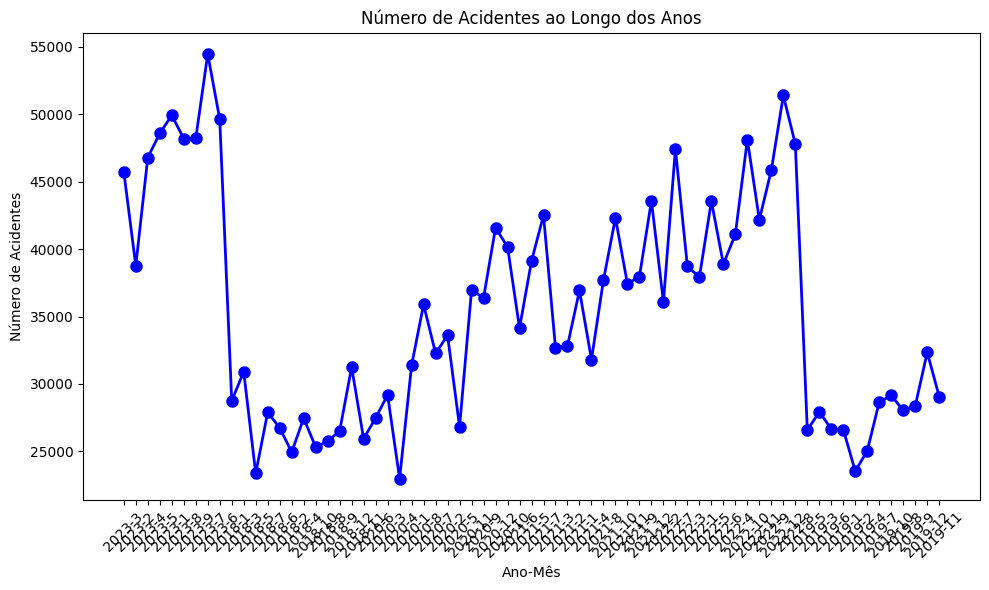

In [68]:
# Vizualização
dados = acidentes_sazional

df = pd.DataFrame(dados)

# Criar um gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(dados['ano'].astype(str) + '-' + dados['mes'].astype(str), dados['count'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionar rótulos e título
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Acidentes')
plt.title('Número de Acidentes ao Longo dos Anos')

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

Resposta:

Aumento de Acidentes em 2020: Durante o ano de 2020, os meses de janeiro, fevereiro e março mostram uma quantidade relativamente alta de acidentes, com uma tendência de aumento ao longo desses meses. É interessante notar que março de 2020 teve uma quantidade significativa de acidentes, possivelmente indicando um aumento antes das restrições da pandemia da COVID-19.

Padrões Anuais: Observa-se uma tendência anual em 2020, com uma diminuição geral nos meses de abril e maio, seguida por um aumento constante nos meses subsequentes. No ano de 2023, essa tendência parece continuar, com picos notáveis nos meses de julho, agosto e setembro.

Aumento nos Últimos Meses: Em 2023, os meses de julho, agosto e setembro têm um aumento acentuado no número de acidentes em comparação com os meses anteriores. Esse aumento pode ser devido a várias razões, como mudanças sazonais, condições meteorológicas ou fatores socioeconômicos.

###Pergunta 7:
###Qual é a condição meteorológica mais apontadas no acidentes graves e mortes ?

In [69]:
Acidente_cond_tempo = dados_unidos.groupBy('condicao_metereologica').agg(f.sum('mortos').alias('total_mortos'), f.sum('feridos_graves').alias('total_feridos_graves'))

# Mostrar o resultado
Acidente_cond_tempo.show()

+----------------------+------------+--------------------+
|condicao_metereologica|total_mortos|total_feridos_graves|
+----------------------+------------+--------------------+
|                 Vento|         173|                 583|
|              Ignorado|        2105|                4163|
|        Garoa/Chuvisco|        3604|                8397|
|      Nevoeiro/Neblina|        1771|                2578|
|                 Chuva|       11678|               30681|
|               Nublado|       16561|               43596|
|                   Sol|        5792|               18166|
|             Céu Claro|       66505|              168327|
|               Granizo|           1|                   3|
|                  Neve|           0|                   4|
+----------------------+------------+--------------------+



In [70]:
# Convertendo resultados em Pandas para gerar visualização
acidentes_por_condições_tempo = Acidente_cond_tempo.toPandas()
acidentes_por_condições_tempo

,condicao_metereologica,total_mortos,total_feridos_graves
0,Vento,173,583
1,Ignorado,2105,4163
2,Garoa/Chuvisco,3604,8397
3,Nevoeiro/Neblina,1771,2578
4,Chuva,11678,30681
5,Nublado,16561,43596
6,Sol,5792,18166
7,Céu Claro,66505,168327
8,Granizo,1,3
9,Neve,0,4


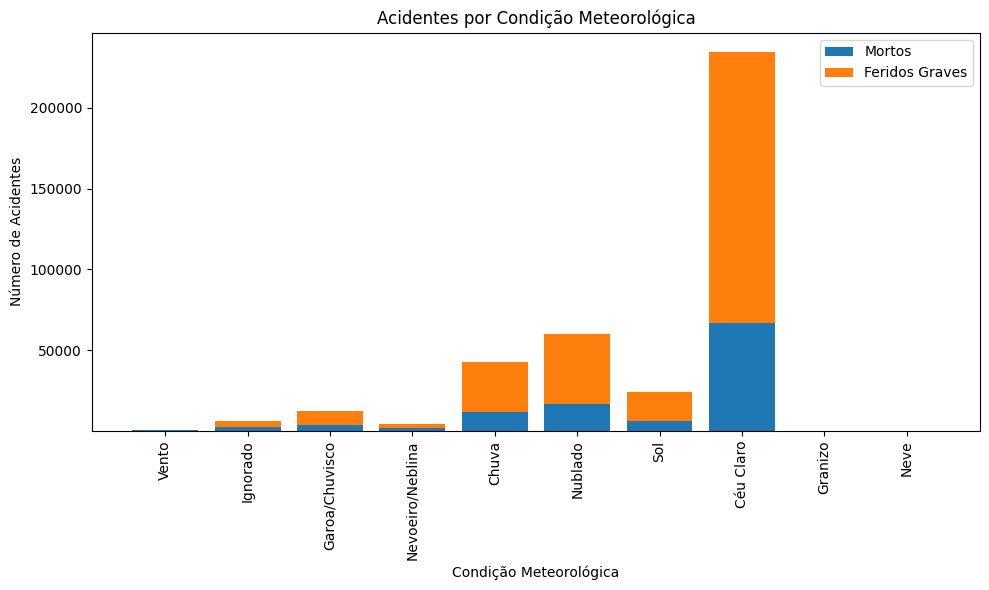

In [71]:
#Visualização

dados = acidentes_por_condições_tempo

df = pd.DataFrame(dados)

# Criar um gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar os dados
ax.bar(dados['condicao_metereologica'], dados['total_mortos'], label='Mortos')
ax.bar(dados['condicao_metereologica'], dados['total_feridos_graves'], bottom=dados['total_mortos'], label='Feridos Graves')

# Adicionar rótulos e título
ax.set_ylabel('Número de Acidentes')
ax.set_xlabel('Condição Meteorológica')
ax.set_title('Acidentes por Condição Meteorológica')
ax.legend()

# Rotacionar rótulos do eixo x para melhor visualização
plt.xticks(rotation=90)

# Exibir o gráfico
plt.tight_layout()
plt.show()


Resposta:

 O dado mais marcante nesta tabela é a condição de "Céu Claro". É surpreendente ver que sob condições de céu claro, houve um número significativamente alto de acidentes, com 66.505 mortos e 168.327 feridos graves.

###Pergunta 8:
###Qual é a relação entre a hora do dia e a gravidade dos acidentes?

In [72]:
# Extrair a hora do campo de horário e calcular a média de mortos e feridos graves
hora_acidentes = dados_unidos.withColumn('hora', f.hour('horario'))

media_gravidade_por_hora = hora_acidentes.groupBy('hora').agg({'mortos':'mean', 'feridos_graves':'mean'})

media_gravidade_por_hora.show()

+----+-------------------+--------------------+
|hora|avg(feridos_graves)|         avg(mortos)|
+----+-------------------+--------------------+
|  12|0.10995378709126277| 0.03432517831595632|
|  22|0.12521891418563924| 0.06258443832874656|
|   1| 0.1339956844426529| 0.07417067792189315|
|  13|0.10444966154801816| 0.03497793895988819|
|   6|0.10733970193429652| 0.04763169628034493|
|  16|0.10475214641557432| 0.03284457478005865|
|   3|0.12522431146134042| 0.07557670801799693|
|  20|  0.129391752667713|0.056019780971336884|
|   5|0.12406279443183779| 0.06632429634937696|
|  19|0.13512563917558115| 0.05494870910060545|
|  15|0.10170604653939729| 0.03313581205128588|
|   9|0.09501769670569017|0.033069503325424916|
|  17| 0.1116228483239256|0.032464257721122124|
|   4|0.11632571958442935| 0.07666105255189902|
|   8|0.09626119802112582| 0.02824575478005081|
|  23|0.12299389957766307| 0.06375723447520726|
|   7|0.09903569948659602| 0.02997548864681879|
|  10|0.09816460113557052|0.029455039329

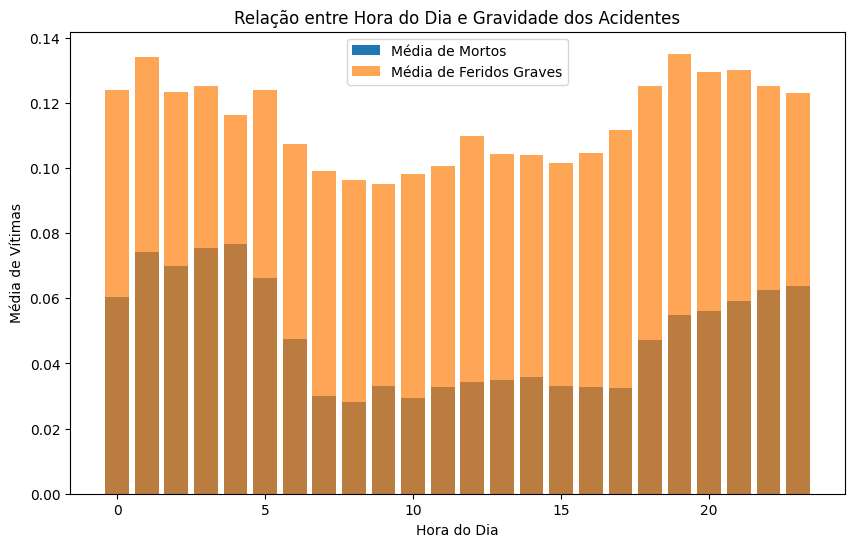

In [73]:
# Visualização:

plt.figure(figsize=(10, 6))
plt.bar(media_gravidade_por_hora.select('hora').rdd.flatMap(lambda x: x).collect(),
        media_gravidade_por_hora.select('avg(mortos)').rdd.flatMap(lambda x: x).collect(),
        label='Média de Mortos')
plt.bar(media_gravidade_por_hora.select('hora').rdd.flatMap(lambda x: x).collect(),
        media_gravidade_por_hora.select('avg(feridos_graves)').rdd.flatMap(lambda x: x).collect(),
        label='Média de Feridos Graves', alpha=0.7)
plt.xlabel('Hora do Dia')
plt.ylabel('Média de Vítimas')
plt.title('Relação entre Hora do Dia e Gravidade dos Acidentes')
plt.legend()
plt.show()


Resposta:

Hora do Dia vs. Feridos Graves:

A proporção média de feridos graves é relativamente consistente ao longo do dia, variando de aproximadamente 9.5% a 13.5%.
As horas com a menor média de feridos graves são 12h e 15h (cerca de 10%), enquanto as horas com a maior média são 19h e 3h (cerca de 13.5%).

Hora do Dia vs. Mortos:

A proporção média de mortos em acidentes também é relativamente constante, oscilando entre aproximadamente 2.8% e 7.5%.
As horas com a menor média de mortos são 8h e 17h (cerca de 3%), enquanto as horas com a maior média são 3h e 4h (cerca de 7.5%).
Padrões Observados:

As horas da madrugada (1h, 3h, 4h) mostram uma tendência a ter acidentes mais graves, tanto em termos de feridos graves quanto de mortos. Isso pode ser devido a condições de visibilidade reduzida e menor presença policial durante essas horas.
As horas de pico durante o dia (12h e 19h) também apresentam uma tendência a ter acidentes mais graves, indicando que mesmo com uma visibilidade relativamente boa, a densidade do tráfego e a velocidade podem contribuir para a gravidade dos acidentes.


###Pergunta 9:
###Qual é o tipo de veículo mais frequentemente envolvido em acidentes graves?

In [75]:
# Filtrar acidentes graves
acidentes_graves = dados_unidos.filter(f.col('classificacao_acidente') == 'Com Vítimas Fatais')

# Contar o número de acidentes graves por tipo de veículo
veiculos_envolvidos = acidentes_graves.groupBy('tipo_veiculo').count().orderBy(f.desc('count'))

veiculos_envolvidos.show()

+----------------+------+
|    tipo_veiculo| count|
+----------------+------+
|       Automóvel|109050|
|     Motocicleta| 49329|
|     Semireboque| 39958|
| Caminhão-trator| 39852|
|          Ônibus| 39773|
|        Caminhão| 32045|
|     Caminhonete| 30709|
|       Bicicleta|  5307|
|      Utilitário|  4756|
|    Micro-ônibus|  4744|
|       Camioneta|  4632|
|         Reboque|  3737|
|        Motoneta|  3457|
|          Outros|  3187|
|   Não Informado|  2765|
|      Ciclomotor|   670|
| Trator de rodas|   239|
|Carroça-charrete|   136|
|      Trem-bonde|    31|
|    Trator misto|    30|
+----------------+------+
only showing top 20 rows



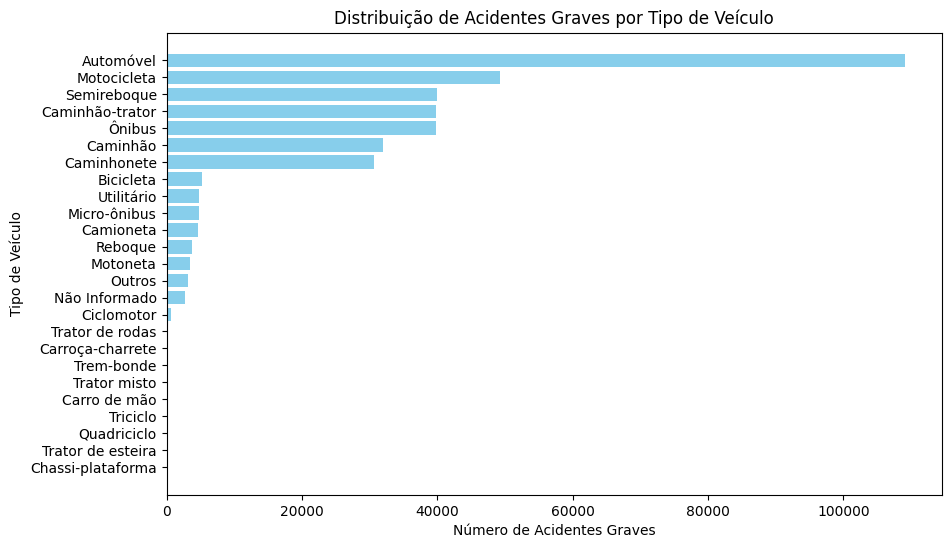

In [76]:
#Visualização:

# Contar o número de acidentes graves por tipo de veículo
veiculos_envolvidos = acidentes_graves.groupBy('tipo_veiculo').count().orderBy('count', ascending=False)

# Dados para o gráfico
categorias = veiculos_envolvidos.select('tipo_veiculo').rdd.flatMap(lambda x: x).collect()
quantidades = veiculos_envolvidos.select('count').rdd.flatMap(lambda x: x).collect()

# Criar o gráfico de barras ordenado
plt.figure(figsize=(10, 6))
plt.barh(categorias, quantidades, color='skyblue')
plt.xlabel('Número de Acidentes Graves')
plt.ylabel('Tipo de Veículo')
plt.title('Distribuição de Acidentes Graves por Tipo de Veículo')
plt.gca().invert_yaxis()
plt.show()

Resposta:

O tipo de veículo mais frequentemente envolvido em acidentes fatais é o Automóvel, com uma contagem significativamente alta de 109,050 acidentes graves.

Seguido por:

Motocicleta, com uma contagem de 49,329 acidentes.

Ônibus, com 39,773 acidentes.

Caminhão-trator com 39,852 acidentes e

Semireboque com 39,958 acidentes graves.

###Pergunta 10:
###Existe alguma relação entre o Tipo da via e a gravidade dos acidentes?

In [77]:
# Calcular média de mortos e feridos graves por estado da via
media_gravidade_estado_via = dados_unidos.groupBy('tracado_via').agg({'mortos':'mean', 'feridos_graves':'mean'})

media_gravidade_estado_via.show()

+--------------------+-------------------+--------------------+
|         tracado_via|avg(feridos_graves)|         avg(mortos)|
+--------------------+-------------------+--------------------+
|                Reta|0.11387757759713102|0.043697958815688075|
|             Viaduto|0.10631475086334484| 0.02014471304061832|
|       Não Informado|0.11017884460504616| 0.05197444955320808|
|  Interseção de vias|0.11671047428531553|0.015770742713591218|
|               Curva|0.11475955141608059| 0.04703240828739783|
|           Rotatória|0.09665166832232805|0.020978203704785835|
|               Túnel|0.11734693877551021|0.012558869701726845|
|Retorno Regulamen...|0.11217333035514854|0.017422381058744694|
|               Ponte| 0.1216525267428993| 0.06219107340464773|
|   Desvio Temporário|0.10465023847376788| 0.04378643349231585|
+--------------------+-------------------+--------------------+



Resposta:

Há variações na média de feridos graves e mortos, dependendo do tipo de via:

Ponte: Acidentes em pontes tendem a ter uma média relativamente alta de feridos graves (12.17%) e mortos (6.22%), indicando uma maior gravidade em comparação com outros tipos de vias.

Interseção de Vias: Acidentes em interseções de vias também têm uma média relativamente alta de feridos graves (11.67%), embora a taxa de mortos seja mais baixa (1.58%) em comparação com pontes.

Curva: Acidentes em curvas têm uma média de feridos graves (11.48%) e mortos (4.70%) um pouco acima da média, sugerindo que curvas podem ser locais propensos a acidentes mais graves.

Não Informado: Acidentes onde o tipo de via não está informado também mostram uma média significativa de feridos graves (11.02%) e mortos (5.20%).

Túnel: Acidentes em túneis têm uma média de feridos graves (11.73%) e mortos (1.26%), indicando que, em média, são menos graves em comparação com outros tipos de vias.

###Conclusão:

Com base no período dos dados analisados sobre acidentes de trânsito (2018 a 2023), algumas conclusões gerais podem ser observadas:

Variação Geográfica: Houve variações significativas nos estados com as maiores taxas de acidentes fatais ao longo dos anos, com destaque para Maranhão, Amazonas, Bahia e Pará. Essa variação pode indicar a necessidade de políticas de segurança viária adaptáveis às condições locais.

Perfil Vítimas infantis: Tanto em acidentes graves quanto em acidentes fatais envolvendo crianças menores de 12 anos, as vítimas têm predominantemente em torno de 6 anos de idade. A grande maioria das mortes se deu por velocidade incompativel, do condutor, o que nos sugere que mais medidas drásticas sobre velocidade precisam ser adotadas.

Principais Causas de Acidentes Fatais: "Falta de Atenção à Condução", "Velocidade Incompatível" e "Desobediência às normas de trânsito pelo condutor" são as principais causas de acidentes fatais, indicando a importância da conscientização e fiscalização nessas áreas.

Relação entre Tipo de Pista e Gravidade dos Acidentes: Acidentes em pistas simples tendem a ser mais graves em termos de fatalidades e ferimentos graves, seguidos por pistas múltiplas e pistas duplas.

Padrões Temporais: Houve um aumento geral no número de acidentes nos últimos meses de 2023. Além disso, as horas da madrugada e as horas de pico durante o dia mostram uma tendência a ter acidentes mais graves.

Em resumo, os dados destacam a complexidade dos padrões de acidentes de trânsito e a necessidade de medidas abrangentes, incluindo educação pública, fiscalização rigorosa e melhorias na infraestrutura viária, para reduzir a incidência e a gravidade dos acidentes no Brasil.